# Estimating $k_j$

>Next, I'd get it working with less and less information assumed to be known. You could either start inferring the participant's stage of disease or the order for biomarkers next. I'd probably do the participant's state of disease.

>For the stage of disease for a participant, I'd do probably derive a gibbs sampling step by calculating each stage's relative likelihood based on the probabilities of the biomarker values ASSUMING they are at that stage. Then you normalize and sample from that discrete distribution.  

## Known $\theta$ and $\phi$

First, let us assume that we know $\theta$ and $\phi$. We also know at which disease stage a biomarker is affected (i.e., $S_n$). Basically, in the `data` below, we do not have these two columns: `k_j` and `affected_or_not`. 

For each participant, I will iterate through all possible stages. For each stage, I will calculate the likelihood of seeing the observed sequence of biomarker values using the following formula:

$$p(X_{j} | S , z_j = 1, k_j) = \prod_{i=1}^{k_j}{p(X_{S(i)j} \mid \theta_n )} \prod_{i=k_j+1}^N{p(X_{S(i)j} \mid \phi_n)}$$


In [1]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import matplotlib.pyplot as plt 
data = pd.read_csv('data/participant_data.csv')
data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data.head()
# but remember that we do not know k_j which is what we are trying to estimate. 

,Biomarker,participant,measurement,k_j,S_n,affected_or_not
0,0,0,1.182988,8,6,affected
1,0,1,1.106062,10,6,affected
2,0,2,29.388512,0,6,not_affected
3,0,3,32.565342,2,6,not_affected
4,0,4,26.612593,4,6,not_affected


Note that in `participant_data.csv`, $S_n \geq 1$ because $S_n$ means the disease stage associated with a specific biomarker. $k_j \geq 0$, indicating that participants may not be in any of the 10 disease stages (i.e., when $k_j = 0$). 

In [2]:
data.S_n.unique()

array([ 6,  3,  7,  1,  4, 10,  5,  8,  9,  2])

In [3]:
data.k_j.unique()

array([ 8, 10,  0,  2,  4,  1,  5,  9,  6,  3,  7])

In [4]:
theta_phi = pd.read_csv('data/means_vars.csv')
theta_phi.head()

,biomarker,theta_mean,theta_var,phi_mean,phi_var
0,0,1.0,0.3,32.0,6.3
1,1,3.0,0.5,31.0,7.4
2,2,5.0,0.2,34.0,9.4
3,3,6.0,1.3,36.0,4.9
4,4,8.0,3.3,38.0,2.5


In [5]:
def compute_single_measurement_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the measurement value of a single biomarker
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of this given measurement value. 

    Note that because the likelihood tends to be very very small, 
    we take the natural log of it

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a scalar
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    var = biomarker_params['theta_var'][0] if affected else biomarker_params['phi_var'][0]
    # sigma = np.sqrt(var)
    likelihood = np.exp(-(measurement - mu)**2/(2*var))/np.sqrt(2*np.pi*var)
    return likelihood

In [6]:
def compute_likelihood(pdata, k_j, theta_phi):
    '''This implementes the formula of https://ebm-book2.vercel.app/distributions.html#known-k-j
    Inputs:
        - pdata: data that belongs to a specific participant
        - k_j: the disease stage the participant is at 
        - theta_phi: a dataframe containing theta and phi means & vars for all biomarkers
    Outputs:
        - the likelihood of seeing this sequence of measurements if the participant is at this k_j
    '''
    likelihood = 1
    for i, row in pdata.iterrows():
        biomarker = int(row['Biomarker'])
        measurement = row['measurement']
        affected = k_j >= row['S_n']
        likelihood *= compute_single_measurement_likelihood(theta_phi, biomarker, affected, measurement)
    return likelihood

In [7]:
# Disable scientific notation
np.set_printoptions(suppress=True)

# biomarkers: [0, 9]
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 1000
# 11 stages in total, [0, 10].
num_stages = len(data.k_j.unique())
estimated_stage_dic = {}
actual_stage_dic = {}

# stages = np.random.randint(0, num_stages, len(participants))

for p in participants:
    p_data = data[data.participant == p].reset_index(drop=True)
    actual_stage_dic[p] = p_data.k_j[0]
    # initiaze stage_likelihood
    stage_likelihood = np.zeros(num_stages)
    for k in range(num_stages):
        # assume participant is in this stage; compute the likelihood of seeing 
        # this sequence of observed biomarker measurement
        # [0, 10] Note that k CAN be 0
        likelihood = compute_likelihood(p_data, k, theta_phi=theta_phi)
        stage_likelihood[k] = likelihood
    likelihood_sum = np.sum(stage_likelihood)
    normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
    sampled_stage = np.random.choice(np.arange(num_stages), p = normalized_stage_likelihood)
    estimated_stage_dic[p] = sampled_stage         

In [8]:
estimated_stages = np.array(list(estimated_stage_dic.values()))
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

In [9]:
def scatter_plot_of_stage_differences(stage_differences):
    '''Scatter Plot of the Difference at each index
    Input:
    - stage_differences: estimated_stages - actual stages. Result should be a 1-dim np array
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(range(100), stage_differences, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Scatter Plot of Stage Difference for Each Participant")
    plt.xlabel("Participant")
    plt.ylabel("Difference (Estimated Stage - True Stage)")
    plt.grid(True)
    plt.show()

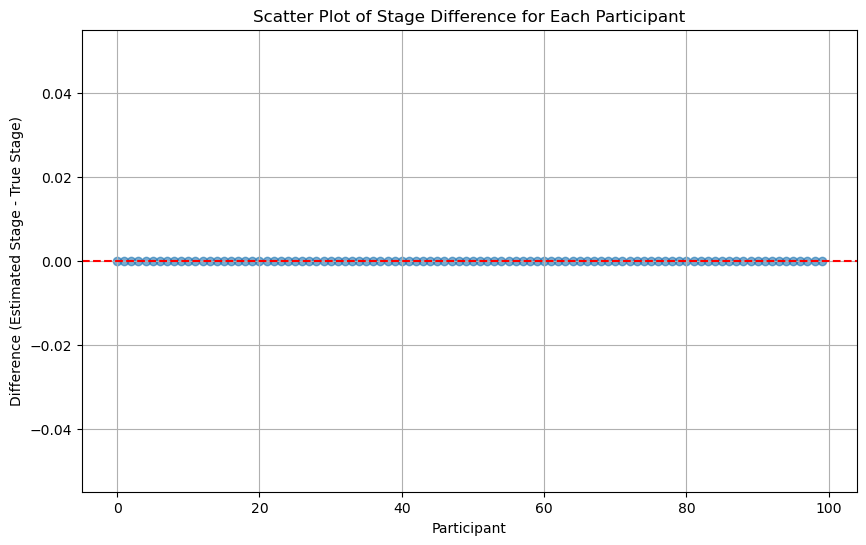

In [10]:
scatter_plot_of_stage_differences(differences)

From the above figure, it is clear that the method we employed is effective as it successfully estimated the stage each participant is in.

## Unknown $\theta$ and $\phi$

Suppose we do not have access to the parameters for biomarker value distributions; i.e., we do not know $\theta$ and $\phi$. 

In [11]:
data_we_have = data.drop(['k_j', 'affected_or_not'], axis = 1)
data_we_have.head()

,Biomarker,participant,measurement,S_n
0,0,0,1.182988,6
1,0,1,1.106062,6
2,0,2,29.388512,6
3,0,3,32.565342,6
4,0,4,26.612593,6


In [12]:
def fill_up_data_we_have(data_we_have, participant_stages, participants):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on the initial or updated participant_stages
    Essentially, all we do below is to get the most accurate participant_stages
    
    Inputs:
        - data_we_have
        - participant_stages: np array 
        - participants: 0-199
    '''
    participant_stage_dic = dict(zip(np.arange(0,len(participants)), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [13]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''This is to estimate means and vars based on conjugate priors
    Inputs:
        - data: a vector of measurements for a specific biomarker in a specific group (affected or not)
        - m0: prior estimate of $\mu$.
        - n0: how strongly is the prior belief in $m_0$ is held.
        - s0_sq: prior estimate of $\sigma^2$.
        - v0: prior degress of freedome, influencing the certainty of $s_0^2$.
    
    Outputs:
        - mu estiate, var estimate
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    return mu_posterior_mean, sigma_squared_posterior_mean

In [14]:
def get_estimated_means_vars_df(biomarkers, data_we_have):
    '''To get estimated parameters, returns a Pandas DataFrame
    Input:
    - biomarkers: 0-9
    - data_we_have: participants data filled with initial or updated participant_stages

    Output: 
    - estimate_means_vars_df, just like means_vars_df, containing the estimated mean and var for 
      distribution of biomarker values when the biomarker is affected and not affected
    '''
    # empty list of dictionaries to store the estimations
    means_vars_estimate_dict_list = []
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.Biomarker == str(biomarker)) & (
            data_we_have.affected == affected)]
            data = np.array(data_full.measurement)
            # if len(data) == 0:
            #     print(data_full)
            mu_estimate, var_estimate = estimate_params_exact(
                m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=data)
            if affected:
                dic['theta_mean'] = mu_estimate
                dic['theta_var'] = var_estimate
            else:
                dic['phi_mean'] = mu_estimate
                dic['phi_var'] = var_estimate
        means_vars_estimate_dict_list.append(dic)
    estimate_means_vars_df = pd.DataFrame(means_vars_estimate_dict_list)
    return estimate_means_vars_df 

### Initialization 

In [15]:
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 10
# note that this is only 1-10, so the num_stage is 10
num_stages = len(data_we_have.S_n.unique())

### Randomized initilization result

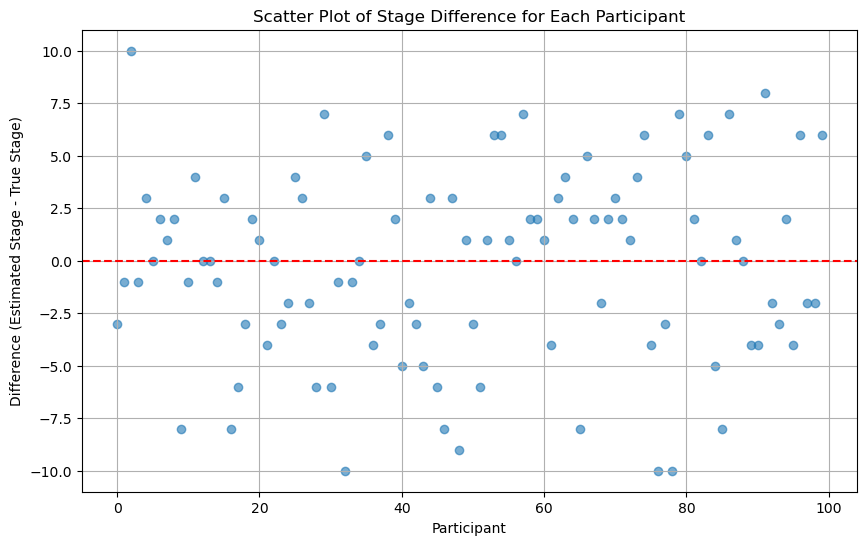

In [16]:
# initialize participant_stages 
# note that high should be num_stages + 1; otherwise, no participants will be in the stage of 10
participant_stages = np.random.randint(low = 0, high = num_stages+1, size = len(participants))

estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

scatter_plot_of_stage_differences(differences)

### Edge cases

Below is an issue I have when I get the maximum rather than taking the weighted random sample:

>When running the function `get_estimated_means_vars_df`, an edge case exists when a biomarker (Say, Biomarker $T$) indicates stage 1. In the initial set-up, since we randomized participant_stages, some participants might be in stage 0. Therefore, for this biomarker, it has both affected and not affected cases. However, this edge case  exists in later iterations where I cannot ensure that the updated `participant_stages` still contains 0. In those scenarios, this biomarker does not have not affected cases. That is to say, in `data_we_have` filled up by that `participant_stages`, the `k_j` column has no values of $0$. 

>Why would this cause issues? Suppose no participants are in stage $0$. Then rows where Biomarker $T$ resides have no `False` in the column of `affected`. Because `estimated_means_vars_df` is obtained from `data_we_have` which is in turn based upon `participant_stages`, `estimated_means_vars_df` does not have values for phi for Biomarker $T$. Then in the following codes, in the `for` loop of `for k in range(num_stages + 1)`, when `k = 0` and `biomarker = T`, we have `affected = False`. When computing `likelihood` there will be an issue because in `estimated_means_vars_df`, there are no `phi` values for biomarker $T$.

>I haven't figured out how to solve this issue. 

I don't have this issue anymore this. Most likely because I will get 0 sometime in each iteration. 

In [17]:
for i in range(num_iterations):
    # fill up data_we_have with the current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, participant_stages, participants)
    estimated_means_vars_df = get_estimated_means_vars_df(biomarkers, data_we_have)
    for p in participants:
        p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
        # initiaze stage_likelihood
        stage_likelihood = np.zeros(num_stages + 1)
        # note that it should be [0, 10]
        for k in range(num_stages + 1):
        # [0, 10] Note that k CAN be 0
            likelihood = compute_likelihood(p_data, k, theta_phi = estimated_means_vars_df)
            stage_likelihood[k] = likelihood
        likelihood_sum = np.sum(stage_likelihood)
        normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
        sampled_stage = np.random.choice(np.arange(num_stages + 1), p = normalized_stage_likelihood)
        participant_stages[p] = sampled_stage         
    print(f"iteration {i} done")

iteration 0 done
iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done


### Result after gibbs sampling

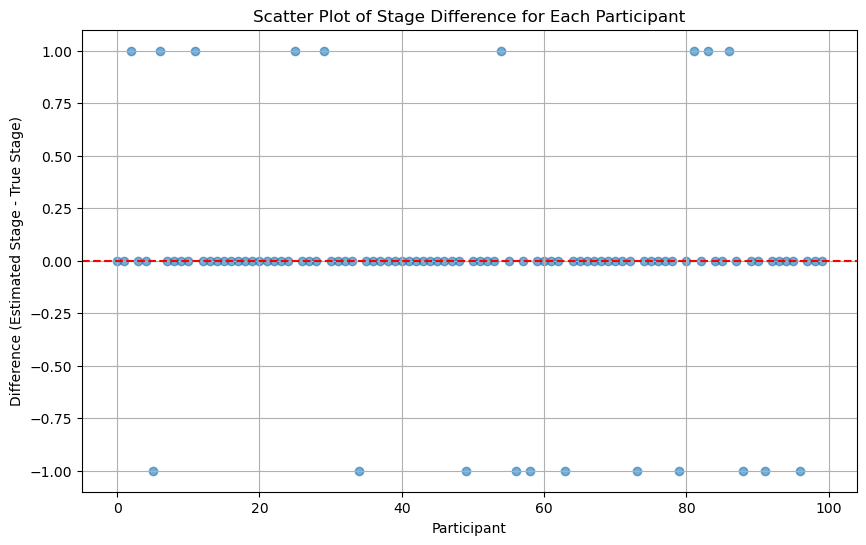

In [18]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages
scatter_plot_of_stage_differences(differences)

### Trying initializing participant stages as the actual stages

We can see that if we initlize participant stages as the actual stages, the result is much better. 

In [19]:
for i in range(num_iterations):
    # fill up data_we_have with the current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, actual_stages, participants)
    estimated_means_vars_df = get_estimated_means_vars_df(biomarkers, data_we_have)
    for p in participants:
        p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
        # initiaze stage_likelihood
        stage_likelihood = np.zeros(num_stages + 1)
        # note that it should be [0, 10]
        for k in range(num_stages + 1):
        # [0, 10] Note that k CAN be 0
            likelihood = compute_likelihood(p_data, k, theta_phi = estimated_means_vars_df)
            stage_likelihood[k] = likelihood
        likelihood_sum = np.sum(stage_likelihood)
        normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
        sampled_stage = np.random.choice(np.arange(num_stages + 1), p = normalized_stage_likelihood)
        participant_stages[p] = sampled_stage         
    print(f"iteration {i} done")

iteration 0 done
iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done


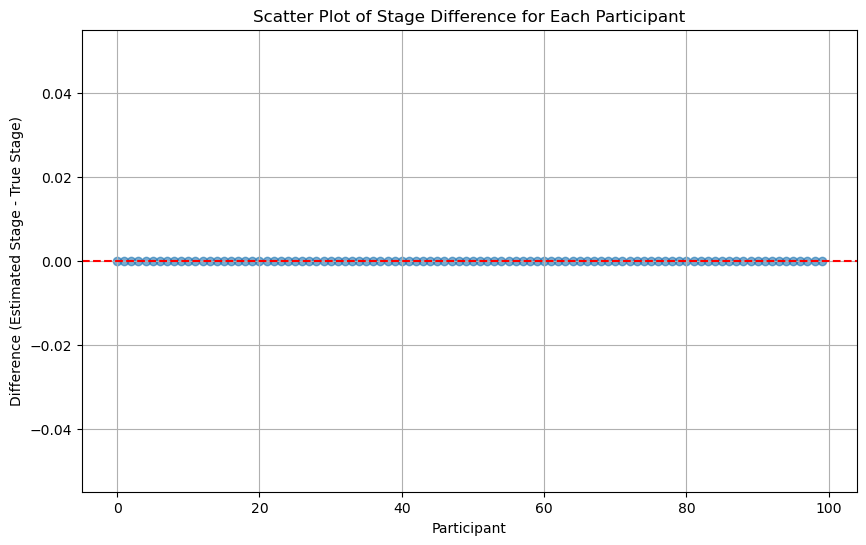

In [20]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages
scatter_plot_of_stage_differences(differences)